In [1]:
# Settings
settings = {}
settings['basemap_csv'] = 'input/scopus2basemap.csv'
settings['canvas_size'] = 3200
settings['stat_test_min'] = 30
settings['k_stat_min_factor'] = 2
settings['barycenter_offset_x'] = -70
settings['barycenter_offset_y'] = 25
settings['scale_ratio'] = 0.273

In [2]:
# Loads and imports
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
import pickle
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

C:\ProgramData\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
# Load nodes aka dots aka keywords
df = pd.read_csv(settings['basemap_csv']).replace({np.nan: None})
df

,Id,x,y,size,showlabel,key,label
0,Galaxy,125.326126,-740.643066,11.263846,False,Galaxy,Galaxy
1,Downlink,-4213.5625,-163.741669,11.263846,False,Downlink,Downlink
2,Eyes,2596.249756,941.393005,11.263846,False,Eyes,Eyes
3,Banach,-2335.763184,175.997345,11.263846,False,Banach,Banach
4,Dosimetric,2253.345215,433.17218,11.263846,False,Dosimetric,Dosimetric
...,...,...,...,...,...,...,...
7557,Feedback,-2047.289551,-663.29718,4.0,False,Feedback,Feedback
7558,Lowering,3246.678467,550.198181,4.0,False,Lowering,Lowering
7559,Usual,3537.695557,911.690796,4.0,False,Usual,Usual
7560,durations,3355.917969,1520.114746,4.0,False,durations,durations


In [4]:
# Compute barycenter
barycenter_x = 0
barycenter_y = 0
count = 0
for index, row in df.iterrows():
    barycenter_x += row['x']
    barycenter_y += row['y']
    count += 1
barycenter_x = barycenter_x / count
barycenter_y = barycenter_y / count
print("Barycenter:",barycenter_x,barycenter_y)

Barycenter: 0.9214623407828252 -1.1867338028298926


In [5]:
# Compute k (for k-means)
kmeans_k = round(len(df) / (settings['k_stat_min_factor'] * settings['stat_test_min']))
print("K means' k is", kmeans_k)

K means' k is 126


In [6]:
# Compute k-means
data = np.column_stack((df['x'], df['y']))

# Initialize the KMeans model with the desired number of clusters
kmeans = KMeans(n_clusters=kmeans_k)

# Fit the model to the data
kmeans.fit(data)

# Get the coordinates of the cluster centers
centroids = kmeans.cluster_centers_

print('Done.')

Done.


In [7]:
# Save centroids
pickle.dump( centroids, open( "cache/centroids.pkl", "wb" ) )

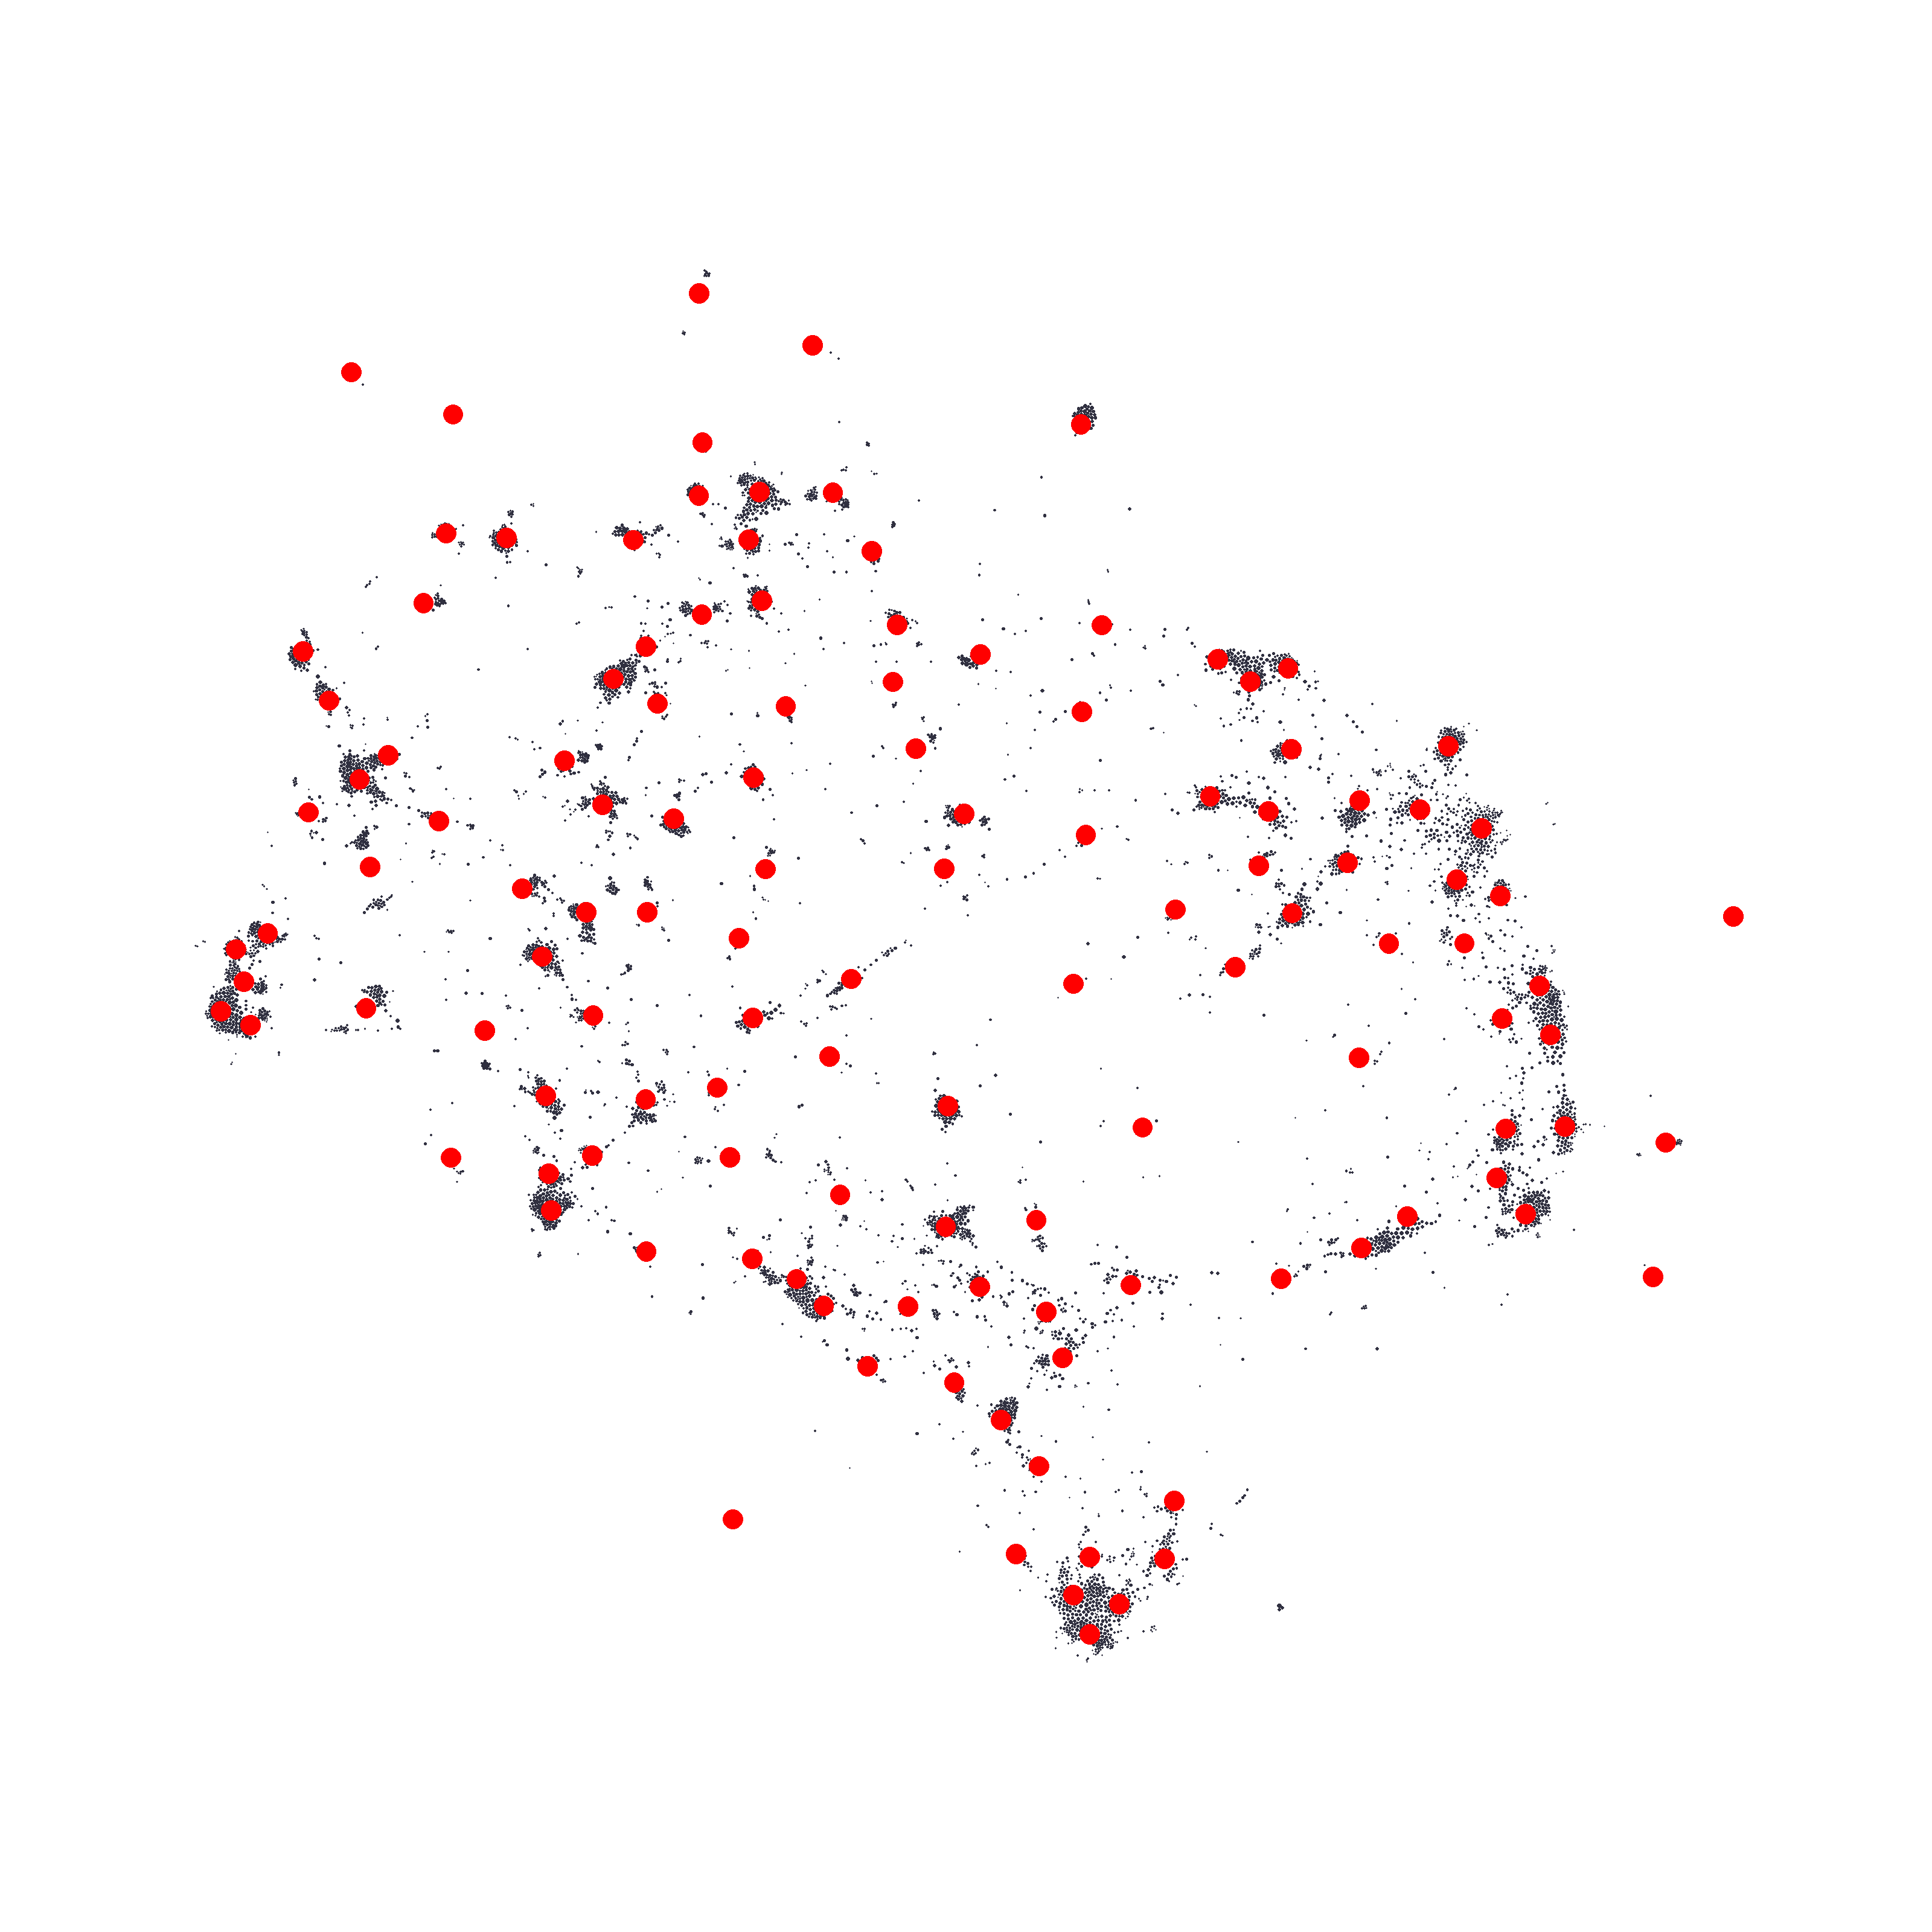

In [8]:
# Render basic visualization (basemap)
# (for monitoring purposes)

# Init canvas
width = settings['canvas_size']
height = settings['canvas_size']
image = Image.new("RGB", (width, height), "white")
draw = ImageDraw.Draw(image)

# Draw a circle
def draw_circle(center_x, center_y, radius, color):
    draw.ellipse([(center_x - radius, center_y - radius),
                  (center_x + radius, center_y + radius)], fill=color)

# Draw nodes
for index, row in df.iterrows():
    x = width/2 + ((row['x'] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
    y = height/2 + (-(row['y'] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
    r = settings['scale_ratio'] * row['size']
    draw_circle(x, y, r, "#303040")

# Draw centroids
for c in centroids:
    x = width/2 + ((c[0] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
    y = height/2 + (-(c[1] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
    r = settings['scale_ratio'] * 60
    draw_circle(x, y, r, "#FF0000")
    
# Base map
image.save("output/basemap_centroids.jpg", "JPEG")
    
display(image)

In [9]:
# Compute average distance to the nearest neighbor

# Calculate pairwise distances between centroids
distances = pairwise_distances(centroids)

# Exclude self-distances by setting diagonal elements to a large value
np.fill_diagonal(distances, np.inf)

# Find the minimum distance for each centroid
min_distances = np.min(distances, axis=1)

# Calculate the average distance
average_distance = np.mean(min_distances)

# Print the average distance
print("Average distance to the nearest neighbor for centroids:", average_distance)

Average distance to the nearest neighbor for centroids: 425.31198867841545


In [10]:
# Compute additional "dummy" centroids to fill the empty space between and around the centroids.
xmin = barycenter_x + ( 0 - settings['barycenter_offset_x'] - settings['canvas_size']/2 ) / settings['scale_ratio']
xmax = barycenter_x + ( settings['canvas_size'] - settings['barycenter_offset_x'] - settings['canvas_size']/2 ) / settings['scale_ratio']
ymin = barycenter_y + ( 0 - settings['barycenter_offset_y'] - settings['canvas_size']/2 ) / settings['scale_ratio']
ymax = barycenter_y + ( settings['canvas_size'] - settings['barycenter_offset_y'] - settings['canvas_size']/2 ) / settings['scale_ratio']

import numpy as np

# Choose up to k points around each reference point as candidates for a new
# sample point
k = 30

# Minimum distance between samples
r = 1.0 * average_distance

width = xmax-xmin
height = ymax-ymin

# Cell side length
a = r/np.sqrt(2)
# Number of cells in the x- and y-directions of the grid
nx, ny = int(width / a) + 1, int(height / a) + 1

# A list of coordinates in the grid of cells
coords_list = [(ix, iy) for ix in range(nx) for iy in range(ny)]
# Initilalize the dictionary of cells: each key is a cell's coordinates, the
# corresponding value is the index of that cell's point's coordinates in the
# samples list (or None if the cell is empty).
cells = {coords: None for coords in coords_list}

def get_cell_coords(pt):
    """Get the coordinates of the cell that pt = (x,y) falls in."""

    return int(pt[0] // a), int(pt[1] // a)

def get_neighbours(coords):
    """Return the indexes of points in cells neighbouring cell at coords.

    For the cell at coords = (x,y), return the indexes of points in the cells
    with neighbouring coordinates illustrated below: ie those cells that could 
    contain points closer than r.

                                     ooo
                                    ooooo
                                    ooXoo
                                    ooooo
                                     ooo

    """

    dxdy = [(-1,-2),(0,-2),(1,-2),(-2,-1),(-1,-1),(0,-1),(1,-1),(2,-1),
            (-2,0),(-1,0),(1,0),(2,0),(-2,1),(-1,1),(0,1),(1,1),(2,1),
            (-1,2),(0,2),(1,2),(0,0)]
    neighbours = []
    for dx, dy in dxdy:
        neighbour_coords = coords[0] + dx, coords[1] + dy
        if not (0 <= neighbour_coords[0] < nx and
                0 <= neighbour_coords[1] < ny):
            # We're off the grid: no neighbours here.
            continue
        neighbour_cell = cells[neighbour_coords]
        if neighbour_cell is not None:
            # This cell is occupied: store this index of the contained point.
            neighbours.append(neighbour_cell)
    return neighbours

def point_valid(pt):
    """Is pt a valid point to emit as a sample?

    It must be no closer than r from any other point: check the cells in its
    immediate neighbourhood.

    """

    cell_coords = get_cell_coords(pt)
    for idx in get_neighbours(cell_coords):
        nearby_pt = samples[idx]
        # Squared distance between or candidate point, pt, and this nearby_pt.
        distance2 = (nearby_pt[0]-pt[0])**2 + (nearby_pt[1]-pt[1])**2
        if distance2 < r**2:
            # The points are too close, so pt is not a candidate.
            return False
    # All points tested: if we're here, pt is valid
    return True

def get_point(k, refpt):
    """Try to find a candidate point relative to refpt to emit in the sample.

    We draw up to k points from the annulus of inner radius r, outer radius 2r
    around the reference point, refpt. If none of them are suitable (because
    they're too close to existing points in the sample), return False.
    Otherwise, return the pt.

    """
    i = 0
    while i < k:
        i += 1
        rho = np.sqrt(np.random.uniform(r**2, 4 * r**2))
        theta = np.random.uniform(0, 2*np.pi)
        pt = refpt[0] + rho*np.cos(theta), refpt[1] + rho*np.sin(theta)
        if not (0 <= pt[0] < width and 0 <= pt[1] < height):
            # This point falls outside the domain, so try again.
            continue
        if point_valid(pt):
            return pt

    # We failed to find a suitable point in the vicinity of refpt.
    return False
    
nsamples = 0
samples = []
active = []

def addStartingPoint(pt, samples, nsamples, active, cells):
    samples.append(pt)
    nsamples += 1
    active.append(len(samples)-1)
    cells[get_cell_coords(pt)] = len(samples) - 1

# Start with centroids.
for c in centroids:
    pt = [c[0]-xmin, c[1]-ymin]
    addStartingPoint(pt, samples, nsamples, active, cells)

# As long as there are points in the active list, keep trying to find samples.
while active:
    # choose a random "reference" point from the active list.
    idx = np.random.choice(active)
    refpt = samples[idx]
    # Try to pick a new point relative to the reference point.
    pt = get_point(k, refpt)
    if pt:
        # Point pt is valid: add it to the samples list and mark it as active
        addStartingPoint(pt, samples, nsamples, active, cells)
    else:
        # We had to give up looking for valid points near refpt, so remove it
        # from the list of "active" points.
        active.remove(idx)

centroids_dummy = []
i = 0
for s in samples:
    if i>=len(centroids):
        c = [xmin+s[0], ymin+s[1]]
        centroids_dummy.append(c)
    i += 1
print(len(centroids_dummy), 'dummy centroids computed.')

381 dummy centroids computed.


In [11]:
# Save dummy centroids
pickle.dump( centroids_dummy, open( "cache/dummy_centroids.pkl", "wb" ) )

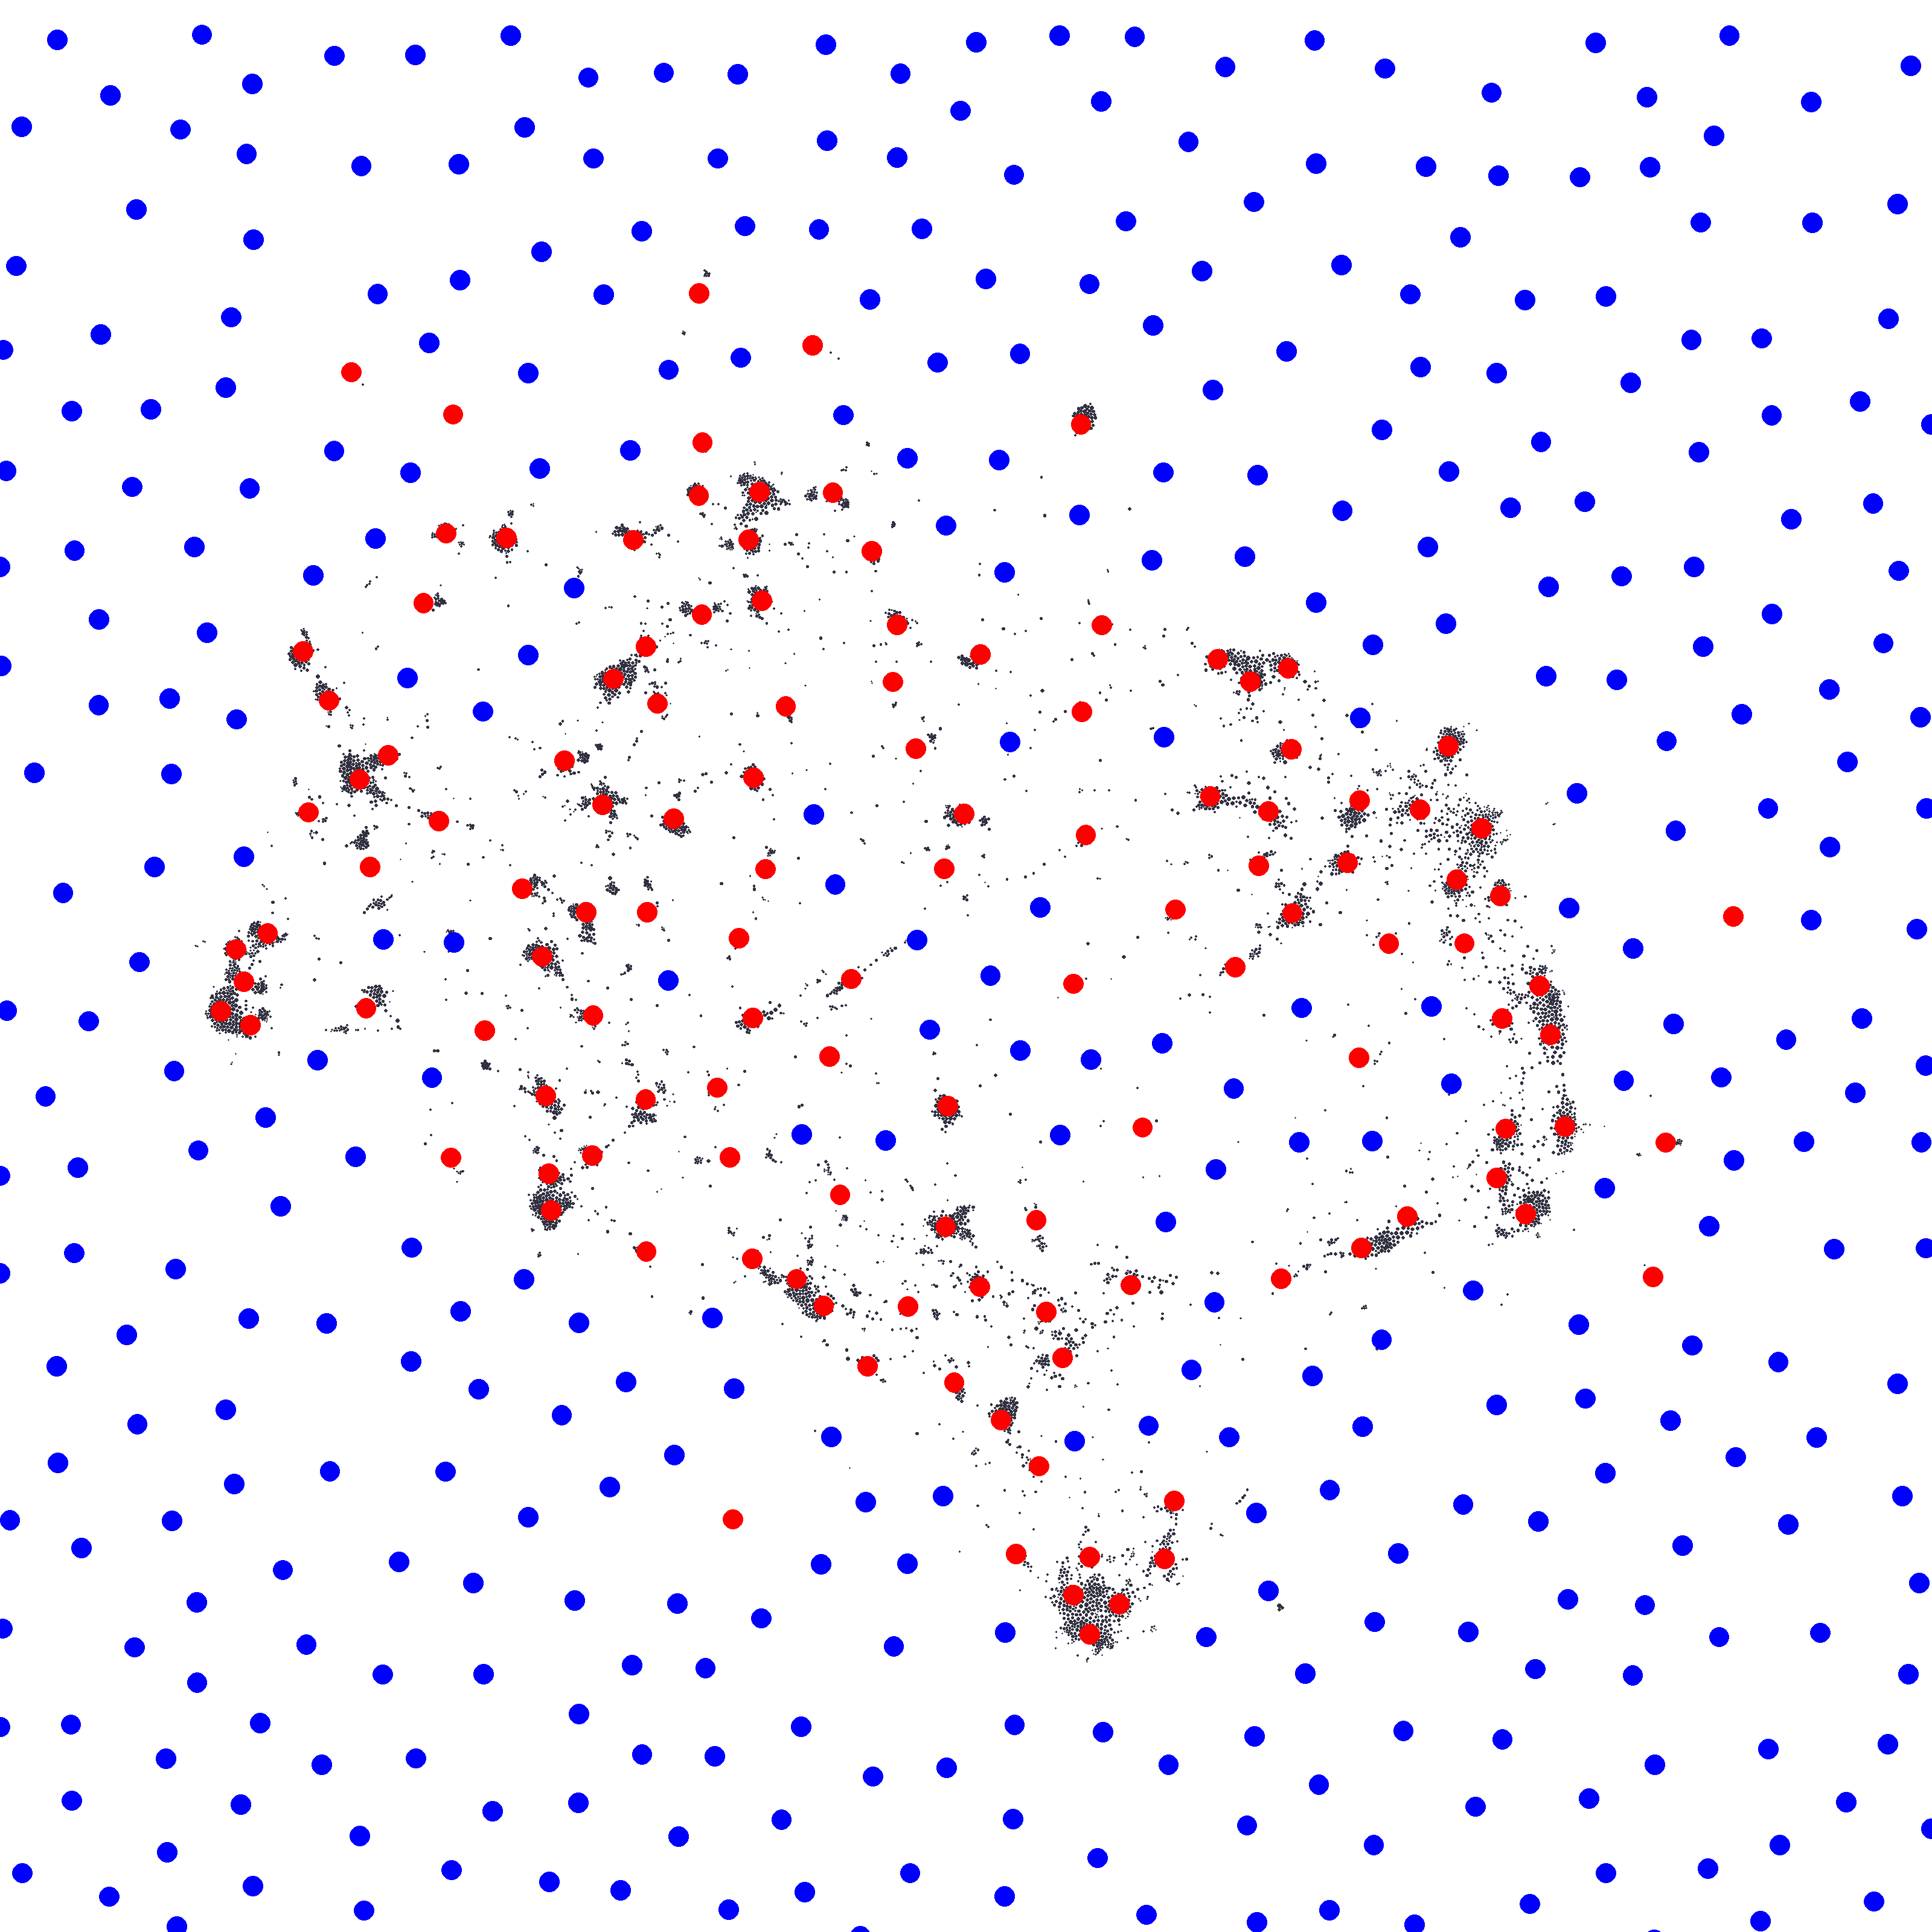

In [12]:
# Render basic visualization (basemap)
# (for monitoring purposes)

# Init canvas
width = settings['canvas_size']
height = settings['canvas_size']
image = Image.new("RGB", (width, height), "white")
draw = ImageDraw.Draw(image)

# Draw a circle
def draw_circle(center_x, center_y, radius, color):
    draw.ellipse([(center_x - radius, center_y - radius),
                  (center_x + radius, center_y + radius)], fill=color)

# Draw nodes
for index, row in df.iterrows():
    x = width/2 + ((row['x'] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
    y = height/2 + (-(row['y'] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
    r = settings['scale_ratio'] * row['size']
    draw_circle(x, y, r, "#303040")

# Draw centroids
for c in centroids:
    x = width/2 + ((c[0] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
    y = height/2 + (-(c[1] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
    r = settings['scale_ratio'] * 60
    draw_circle(x, y, r, "#FF0000")

# Draw additional centroids
for c in centroids_dummy:
    x = width/2 + ((c[0] - barycenter_x) * settings['scale_ratio']) + settings['barycenter_offset_x']
    y = height/2 + (-(c[1] - barycenter_y) * settings['scale_ratio']) + settings['barycenter_offset_y']
    r = settings['scale_ratio'] * 60
    draw_circle(x, y, r, "#0000FF")
    
# Base map
image.save("output/basemap_centroids.jpg", "JPEG")
    
display(image)